In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 12.0)
matplotlib.rcParams['axes.titlesize'] = 18

In [143]:
train = pd.read_csv('input/train.csv.zip', parse_dates=['Dates'])
test = pd.read_csv('input/test.csv.zip', parse_dates=['Dates'])

In [144]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Let's first see if there are missing values in our data.

In [145]:
train.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

In [146]:
test.isnull().sum()

Id            0
Dates         0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64

Nice. So we have no missing values.


Other competitors have had success creating a categorical 'location' variable using latitude and longitude, so we'll do the same.

Below, we round lattitude and longitude to two decimal places, then concatenate them into a string we call 'location'.

In [ ]:
def encodeLoc(x):
    return  '{}_{}'.format(str(round(x.X,2)), str(round(x.Y, 2)))

train['location'] = train.apply(encodeLoc, axis=1)
test['location'] = test.apply(encodeLoc, axis=1)

That took a while, so let's save the output.

In [ ]:
train.to_csv('train_with_loc.csv', index=False)
test.to_csv('test_with_loc.csv', index=False)

In [2]:
train = pd.read_csv('train_with_loc.csv', parse_dates=['Dates'])
test = pd.read_csv('test_with_loc.csv', parse_dates=['Dates'])

In [3]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,location
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,-122.43_37.77
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,-122.43_37.77
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,-122.42_37.8
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,-122.43_37.8
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,-122.44_37.77


In [4]:
train.location.nunique(), test.location.nunique()

(139, 140)

Now let's encode our location strings as integers. One complication is that there is a location in the test set that is not in the training set. So we cheat a bit and fit the encoder on the test locations.

In [5]:
locEnc = sklearn.preprocessing.LabelEncoder()
locEnc.fit(test.location.unique())
test['location'] = locEnc.transform(test.location)
train['location'] = locEnc.transform(train.location)

In [6]:
train.location.head()

0    50
1    50
2    42
3    53
4    61
Name: location, dtype: int64

Now we'll preprocess the other columns using the function below.

In [7]:
from sklearn.preprocessing import LabelEncoder
categoryEncoder = LabelEncoder() #save as variable so we can use later while creating submission


def clean(df, isTrain=True):
    ## we need to clean the train and tests sets somewhat differently, hence the isTrain argument above
    
    ## transform the variable we will predict into a numeric category so our model can handle it. 
    if (isTrain):
        df['Category'] = categoryEncoder.fit(df.Category).transform(df.Category)
    
    ## parse the Date variable into component parts so that our model can take advantage of that information
    df['month'] = df.Dates.dt.month
    df['dayOfMonth'] = df.Dates.dt.day
    df['year'] = df.Dates.dt.year
    df['hour'] = df.Dates.dt.hour
    
    
    #create dummy variables for our categorical variables 
    df = df.merge(pd.get_dummies(df, columns=['DayOfWeek', 'year', 'month', 'PdDistrict', 'dayOfMonth', 'hour']))
    
    dropForTrain = [
                    'Descript', #Not in test, so not helpful for modeling
                    'Dates',  #We've parsed it into components
                    'Resolution', #Not in test, so not helpful for modeling
                    'Address',  # Too many unique values to dummy encode
                    'month', #Dummy Encoded Columns
                    'dayOfMonth', 
                    'hour',
                    'year',
                    'DayOfWeek',
                    'PdDistrict'
                    ]
    
    dropForTest = [
        'Dates', 
        'Address', 
        'year',
        'DayOfWeek',
        'month', 
        'dayOfMonth', 
        'hour',
        'PdDistrict'
    ]
    
    if (isTrain):
        df = df.drop(dropForTrain, axis=1)
    else:
        df = df.drop(dropForTest, axis=1)
    
    return df
    

In [8]:
trainClean = clean(train)

In [9]:
testClean = clean(test, isTrain=False)

In [10]:
trainClean.shape, testClean.shape

((883987, 101), (884262, 101))

## Training a logistic regression classifier

Let's train our model. First, we'll split the data into our features and our target.

In [12]:
X = trainClean.drop('Category', axis=1)
y = trainClean.Category

We'll train a logistic regression classifier and tune 'C', its regularization parameter. We use multinomial logistic regression instead of one-vs-all because the Kaggle competition is judged on log loss. Mutinomial produces better calibrated probabilities than one-vs-all, and so should perform better in respect to log loss.

In [139]:
softMax = LogisticRegression(multi_class='multinomial', solver='lbfgs', tol=1e-2, max_iter=50)
softMaxParams = {'C': [1e-3, 1e-2, 1e-1, 1]}

gs = GridSearchCV(estimator = softMax, param_grid=softMaxParams, verbose=5, scoring='log_loss') 
gs.fit(X, y)

print(gs.best_params_)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.001 .........................................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ............................... C=0.001, score=-2.672714 - 1.7min
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ............................... C=0.001, score=-2.665976 - 1.7min
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ............................... C=0.001, score=-2.665822 - 1.7min
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.2min remaining:    0.0s
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ................................ C=0.01, score=-2.672670 - 1.5min
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.7min remaining:    0.0s
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ................................ C=0.01, score=-2.665987 - 1.6min
[CV] C=0.01 ..........................................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ................................ C=0.01, score=-2.665749 - 1.6min
[CV] C=0.1 ...........................................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ................................. C=0.1, score=-2.672710 - 1.6min
[CV] C=0.1 ...........................................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ................................. C=0.1, score=-2.665988 - 1.5min
[CV] C=0.1 ...........................................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ................................. C=0.1, score=-2.665749 - 1.5min
[CV] C=1 .............................................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ................................... C=1, score=-2.672717 - 1.5min
[CV] C=1 .............................................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ................................... C=1, score=-2.665988 - 1.5min
[CV] C=1 .............................................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:137: DeprecationWarning: Scoring method log_loss was renamed to neg_log_loss in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV] ................................... C=1, score=-2.665749 - 1.5min


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 19.0min finished


{'C': 0.01}


Our best 'C' parameter is 0.01. Let's create a validation set to check out our model's predictions

In [80]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((707189, 100), (176798, 100), (707189,), (176798,))

In [81]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', tol=1e-2, max_iter=50, C= 0.01)
lr.fit(X_train, y_train)
probs = lr.predict_proba(X_test)

In [82]:
cats = categoryEncoder.inverse_transform(np.arange(train.Category.nunique()))

In [83]:
probs_df = pd.DataFrame(probs, columns=cats)

In [84]:
probs_df.head()

,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0.001703,0.077282,0.000396,0.000153,0.048909,0.003605,0.003413,0.026958,0.004855,0.001333,...,0.000049,0.004856,0.000550,0.040245,0.000010,0.007195,0.059616,0.070659,0.034819,0.006702
1,0.001722,0.078715,0.000407,0.000162,0.048320,0.003751,0.003316,0.029326,0.004896,0.001332,...,0.000052,0.004900,0.000563,0.039936,0.000010,0.007320,0.058939,0.069831,0.036169,0.006972
2,0.001813,0.087554,0.000482,0.000237,0.043049,0.004902,0.002584,0.052028,0.005064,0.001276,...,0.000083,0.005088,0.000646,0.036374,0.000020,0.008078,0.052311,0.062459,0.046393,0.009129
3,0.001842,0.092646,0.000537,0.000313,0.038491,0.005907,0.002069,0.080188,0.005069,0.001204,...,0.000117,0.005113,0.000703,0.033006,0.000032,0.008523,0.046358,0.055889,0.055161,0.011013
4,0.001764,0.082555,0.000438,0.000190,0.046165,0.004208,0.002993,0.037345,0.004980,0.001311,...,0.000064,0.004991,0.000598,0.038453,0.000014,0.007648,0.056211,0.066918,0.040262,0.007829


Let's reshape our dataframe to make plotting easier.

In [85]:
probs_stack = probs_df.stack().reset_index().rename(columns={'level_0': 'example', 0:'probability', 'level_1': 'category'})
probs_stack.head()

,example,category,probability
0,0,ARSON,0.001703
1,0,ASSAULT,0.077282
2,0,BAD CHECKS,0.000396
3,0,BRIBERY,0.000153
4,0,BURGLARY,0.048909


In [86]:
probs_stack.example.value_counts().describe()

count    176798.0
mean         39.0
std           0.0
min          39.0
25%          39.0
50%          39.0
75%          39.0
max          39.0
Name: example, dtype: float64

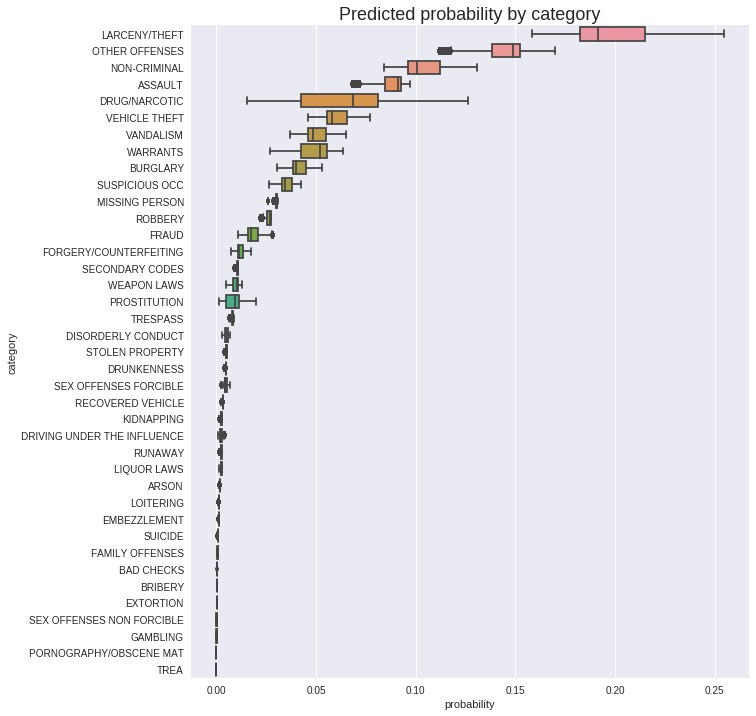

In [110]:
fig, ax= plt.subplots(1,1, figsize=(10, 12))
order = probs_unstack.groupby('category').probability.mean().sort_values(ascending=False).index.values
sns.boxplot(y='category', x='probability', data=probs_stack, order=order, ax=ax)
_ = ax.set_title('Predicted probability by category')
plt.savefig('imgs/probs.png')

In [109]:
preds = lr.predict(X_test)
num_right = (preds == y_test.values).sum()  
num_ex = len(y_test)
num_right*1.0 / num_ex*1.0

0.1992613038609034

Above we see that our model predicts that larceny/theft is the correct category for most if not all examples, and that it is correct 20% of the time.

## Making predictions and creating the submission file

Let's create our submission using the helper function below.

In [125]:
num_cats = train.Category.nunique()
def createSubmission(est, filePath):
    
    #get the category names for the header of the submission file.
    catLabels = categoryEncoder.inverse_transform(np.arange(num_cats))

    #because we've already selected our hyperparameters, we can now fit our estimator on the entire training set
    est.fit(X, y)
    
    # get the probabilities that a crime belongs to each category.
    testProbs = est.predict_proba(testClean.drop('Id', axis=1))
    
    #create our data frame and save it as a csv.
    subDf = pd.DataFrame(testProbs, columns=catLabels)
    subDf = pd.concat([testClean.Id, subDf], axis=1)
    subDf.to_csv(filePath, index=False)
    print('created {}'.format(filePath))
    return subDf


Now let's use our function to create our submission!

In [126]:
sub = createSubmission(gs.best_estimator_, 'my_submission_7.csv')

created my_submission_7.csv


In [127]:
sub.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.001620,0.074269,0.000419,0.000151,0.050240,0.003258,0.003807,0.021296,0.004571,...,0.000042,0.004628,0.000548,0.041416,0.000006,0.006741,0.061511,0.072948,0.031431,0.006096
1,1,0.001881,0.094255,0.000583,0.000382,0.035763,0.006491,0.001746,0.099967,0.005205,...,0.000140,0.005026,0.000732,0.030857,0.000036,0.008974,0.043280,0.051815,0.059636,0.011861
2,2,0.001832,0.088728,0.000531,0.000279,0.041816,0.005183,0.002396,0.058244,0.005108,...,0.000092,0.005020,0.000677,0.035398,0.000020,0.008316,0.050734,0.060470,0.048505,0.009547
3,3,0.001826,0.088292,0.000525,0.000270,0.042407,0.005057,0.002476,0.054933,0.005094,...,0.000088,0.005015,0.000671,0.035907,0.000018,0.008241,0.051599,0.061636,0.047379,0.009329
4,4,0.001826,0.088292,0.000525,0.000270,0.042407,0.005057,0.002476,0.054933,0.005094,...,0.000088,0.005015,0.000671,0.035907,0.000018,0.008241,0.051599,0.061636,0.047379,0.009329
